# Research Assistant

## Review

In the previous modules, we've explored key themes:

- Memory
- Human-in-the-loop
- Controllability

Now, we aim to bring these ideas together to trackle one of AI's most widespread application: research automation.

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this burden.

However, research demands customization: raw LLM outputs are often poorly suited for real-world workflows or challenging decisions.

Customized, LLM-based research and report generation is a promising way to AI system to play a role in decision-making processes.

## Goal

Our goal is to build a lightweight, multi-agent system around LLMs that optimizes and cusomizes the research process.

`Source Selection`

- Users can choose any set of input sources for their research.

`Planning`

- Users provide a topic, and the system generates a team of AI analysts, each focusing on sub-topics.
- `Human-in-the-loop` will refine these sub-topics before research begins.

`LLM Utilization`

- Each analyst will conduct in-depth interviews with an expert AI using selected sources.
- This will employ multi-turn conversations to extract detailed insights as shown in the STORM paper.
- These interviews will be captured in a using `sub-graphs`.

`Research Process`

- Experts will gather information in `parallel`.
- All interviews will be conducted simultanously through `map-reduce`.

`Output Format`

- The gathered insights will be synthesized into a final report.
- We'll use customizable prompts for the report structures.

<center><img src="../../../assets/researcher.png" width=900 alt="researcher"></img></center>

## Dependencies

In [1]:
import os
import operator
from typing import List, TypedDict, Annotated, Annotated
from pydantic import BaseModel, Field
from IPython.display import display, Image, Markdown
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import get_buffer_string
from dotenv import load_dotenv
import json
load_dotenv()

True

## Model

In [2]:
model = ChatOllama(
    model="llama3.1-tool",
    base_url="http://localhost:11434",
    temperature=0.1,
    max_tokens=4096,
)

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [3]:
class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst."
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns and motives."
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations."
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research Topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human Feedback
    analysts: List[Analyst] # Analysr asking questions

In [4]:
analyst_instructions = """You are tasked with creating a set of AI analyst personas to analyze the following topic. For each analyst, you MUST provide ALL of the following fields:

Topic to analyze: {topic}

Required fields for EACH analyst:
1. name: A distinctive professional name
2. role: Their specific role or position
3. affiliation: Their organization or institutional affiliation
4. description: A detailed paragraph about their expertise, perspective, and approach to the topic

Additional Context:
- Number of analysts to generate: {max_analysts}
- Feedback to consider: {human_analyst_feedback}

Guidelines:
- Each analyst should represent a unique perspective or aspect of the topic
- Descriptions must be detailed and specific to the topic
- All fields must be provided for each analyst
- Each analyst should have a clear focus area within the topic

Please generate exactly {max_analysts} analysts with all required fields fully completed."""

In [5]:
model_perspective = ChatOllama(
    model="llama3.1",
    base_url="http://localhost:11434",
    temperature=0.1,
    num_predict=-1,
    num_ctx=20000,
    format=Perspectives.model_json_schema()
)

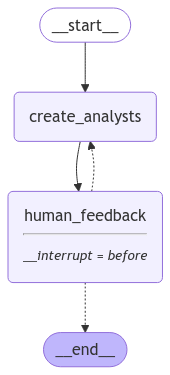

In [6]:
def create_analysts(state: GenerateAnalystsState):

    """Create analysts"""
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")

    # Enforce structured output
    structured_llm = model.with_structured_output(Perspectives)

    # System Message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )

    analysts = structured_llm.invoke(
            [
                SystemMessage(content=system_message),
                HumanMessage(content="Generate the complete set of analysts with all required fields.")
            ]
        )
    
    print("Analysts: ", analysts)

    return {"analysts": analysts.analysts}
    # try:
        

    #     # Normalize field names
    #     normalized_analysts = []
    #     for analyst in analysts.analysts:
    #         if isinstance(analyst, dict):
    #             normalized_data = {key.lower(): value for key, value in analyst.items()}
    #         else:
    #             normalized_data = {
    #                 "name": analyst.name,
    #                 "role": analyst.role,
    #                 "affiliation": analyst.affiliation,
    #                 "description": analyst.description
    #             }
    #         normalized_analysts.append(normalized_data)

    #     # Fill missing fields with defaults if necessary
    #     complete_analysts = [
    #         Analyst(**{
    #             "name": analyst.get("name", "Unknown Analyst"),
    #             "role": analyst.get("role", "Undefined Role"),
    #             "affiliation": analyst.get("affiliation", "Independent"),
    #             "description": analyst.get("description", "Detailed description pending.")
    #         })
    #         for analyst in normalized_analysts
    #     ]

        

    # except Exception as e:
    #     raise ValueError(f"Error generating analysts: {e}")


def human_feedback(state: GenerateAnalystsState):
    """No operation node: Here comes the human feedback"""
    pass

def should_continue(state: GenerateAnalystsState):
    """Return the next node to execute"""

    # Check if human feedback
    human_analyst_feedback = state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analysts"
    return END

builder = StateGraph(GenerateAnalystsState)

builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START,"create_analysts")
builder.add_edge("create_analysts","human_feedback")
builder.add_conditional_edges("human_feedback", should_continue,["create_analysts",END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)


display(Image(graph.get_graph().draw_mermaid_png()))


In [7]:
max_analysts: int = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable":{"thread_id":"3"}}

# Run the graph until the first interruption
for event in graph.stream({
    "topic":topic,
    "max_analysts":max_analysts,
}, thread, stream_mode="values"):
    
    # Review
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)


Analysts:  analysts=[Analyst(affiliation='LangGraph Institute', name='AI Analyst 1', role='Senior Researcher', description='Dr. AI Analyst 1 is a renowned expert in agent frameworks and their applications. With over a decade of experience, she has led numerous research projects focusing on the benefits of adopting LangGraph as an agent framework. Her expertise lies in analyzing complex systems and identifying key performance indicators for successful implementation.'), Analyst(affiliation='University of AI Research', name='AI Analyst 2', role='Research Scientist', description='Dr. AI Analyst 2 is a highly respected researcher with a strong background in artificial intelligence and machine learning. He has published several papers on the topic of LangGraph adoption, highlighting its potential for improving efficiency and scalability.'), Analyst(affiliation='Data Science Lab', name='AI Analyst 3', role='Senior Data Scientist', description='Ms. AI Analyst 3 is a seasoned data scientist wi

In [8]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
graph.update_state(thread, {
    "human_analyst_feedback": "Add in someone from a startup to add an entrepeneur perspective"
}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe3580-49ba-6c2e-8002-110922911476'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)

Name: AI Analyst 1
Affiliation: LangGraph Institute
Role: Senior Researcher
Description: Dr. AI Analyst 1 is a renowned expert in agent frameworks and their applications. With over a decade of experience, she has led numerous research projects focusing on the benefits of adopting LangGraph as an agent framework. Her expertise lies in analyzing complex systems and identifying key performance indicators for successful implementation.
--------------------------------------------------
Name: AI Analyst 2
Affiliation: University of AI Research
Role: Research Scientist
Description: Dr. AI Analyst 2 is a highly respected researcher with a strong background in artificial intelligence and machine learning. He has published several papers on the topic of LangGraph adoption, highlighting its potential for improving efficiency and scalability.
--------------------------------------------------
Name: AI Analyst 3
Affiliation: Data Science Lab
Role: Senior Data Scientist
Description: Ms. AI Analyst 

In [11]:
further_feedback = None
graph.update_state(thread, {
    "human_analyst_feedback": further_feedback
}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe3580-af03-68e6-8004-de5e076a6c72'}}

In [12]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print("--- Node ---")
    node_name = next(iter(event.keys()))
    print(node_name)

--- Node ---
topic


In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-"*50)

Name: AI Analyst 1
Affiliation: Stanford University
Role: Research Scientist
Description: Dr. AI Analyst 1 is a renowned expert in natural language processing and machine learning. With a Ph.D. in Computer Science from Stanford, she has published numerous papers on the application of deep learning to text analysis. Her research focuses on developing more accurate and efficient methods for sentiment analysis and topic modeling.
--------------------------------------------------
Name: AI Analyst 2
Affiliation: Google
Role: Data Scientist
Description: Mr. AI Analyst 2 is a seasoned data scientist with over a decade of experience in working with large-scale datasets. He has worked on various projects involving recommendation systems, clustering algorithms, and network analysis. His expertise lies in identifying patterns and trends in complex data sets.
--------------------------------------------------
Name: AI Analyst 3
Affiliation: Startup Founder
Role: Entrepreneur
Description: Ms. AI A

## Conduct Interview

### Generate Question

The analysi will ask questions.

In [16]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    query: str = Field("",description="The query for a search task on web or documents")

In [17]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
2. Specific: Inights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [18]:
def generate_question(state:InterviewState):
    """Node to generate a question"""

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Geenerate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = model.invoke([SystemMessage(content=system_message)] + messages)

    print("Question: ", question.content)

    # Write messages to state
    return {"messages": [question]}

## Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel.

Here we can be very flexible. For example, we can use:

- Specific websites e.g., via `WebBaseLoader`
- Indexed documents
- Web search
- Wikipedia search

You can try different web search tools. `Tavily` is one nice option to consider, but enure your `TAVILY_API_KEY` is set.

In [19]:
tavily_search = TavilySearchResults(
    max_results=3, 
    api_wrapper=TavilySearchAPIWrapper(
        tavily_api_key=os.getenv("TAVILY_API_KEY")
    )
)

In [20]:
search_agent = ChatOllama(
    model="llama3.1",
    base_url="http://localhost:11434",
    temperature=0.1,
    num_ctx=56000,  # Reduce context length
    num_predict=5000,  # Limit token generation,
    format=SearchQuery.model_json_schema()
)

In [21]:
search_instructions = SystemMessage(content="""You will be given a conversation between an analyst and an expert.
Analyze the full conversation and pay attention to the final questions posed by the analyst.
Your goal is to generate a well-structured search query for use in retrieval and /or web-search relaed to the conversation.
Convert this final question into a well-structured web search query.
Return ONLY a valid JSON object in this format:

```json
{
    "query": "<search query here>"
}
```
""")


In [22]:
def search_web(state:InterviewState):

    """Retrieves docs from web search"""
    
    message = search_agent.invoke([search_instructions] + state["messages"])
   
    search_query = SearchQuery(**json.loads(message.content))

    print("Query: ", search_query.query)

    # Search
    search_docs = tavily_search.invoke(search_query.query)

    # Format
    formatted_search_docs = "\n\n--\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    print("Tavily Docs: ", formatted_search_docs)
    return {"context": [formatted_search_docs]}

def search_wiki(state: InterviewState):

    """Retrieves docs from wikipedia"""
    
    
    message = search_agent.invoke([search_instructions] + state["messages"])

    search_query = SearchQuery(**json.loads(message.content))
        
    print("Query: ", search_query.query)
    # Search
    search_docs = WikipediaLoader(
        query=search_query.query,
        load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n--\n\n".join(
        [
           f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page","")}"/>\n{doc.page_content}\n</Document>' 
            for doc in search_docs
        ]
    )
    
    print("Wiki Docs: ", formatted_search_docs)
    return  {"context":[formatted_search_docs]}

In [23]:
answer_agent = ChatOllama(
    model="llama3.1",
    base_url="http://localhost:11434",
    temperature=0.1,
    num_ctx=56000,  # Reduce context length
    num_predict=-1,  # Limit token generation,
)

In [24]:
answer_instructions = """You are an expert being interviewed by analyst.

Here is analyst area of focus: {goals}.

Your goal is to answer a question posed by the interviewer.

To answer question, use this context: 

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. The context contain sources at the topic of each individual document.
4. Include these sources in your answer next to any relevant statements.  For example, for source # 1 use [1].
5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
6. If the source is: '<Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:
 [1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation.
"""

def generate_answer(state: InterviewState):

    """Node to answer a question"""

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer the question
    system_message = answer_instructions.format(
        goals=analyst.persona,
        context=context
    )
    answer = answer_agent.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to the state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save the interviews"""
    messages = state["messages"]

    # Convert interviews to a string
    interview = get_buffer_string(messages)

    return {"interview": interview}

def route_messages(state: InterviewState, name: str = "expert"):

    """Route between question and answer"""

    # Get the messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # Check the number of expert answers
    num_responses = len(
        [
            m for m in messages if isinstance(m,AIMessage) and m.name == name
        ]
    )

    # End if expert has answered more than max_turns
    if num_responses >= max_num_turns:
        return 'save_interview'


    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    
    return "ask_question"

In [25]:
section_writter_instructions = """You are an expert technical writter.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown fomatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview.
- Create a numbered list of source documents, as you use them.
- Do not mention the names of interviewers or experts
- Aim for approximately 600 words.
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Usse two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to no repete the sources. For example, this isn't correct:
[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

This is correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Finnal review:
- Ensure the report follows the required structure
- Include no preamblo before the title of the report
- Check that all guidelines have been followed.
"""

In [26]:
def write_section(state: InterviewState):

    """Node to answer the question"""

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself
    system_message = section_writter_instructions.format(focus=analyst.description)
    section = answer_agent.invoke(
        [
            SystemMessage(content=system_message)
        ] + [
            HumanMessage(
                content=f"Use this soruce to write your section: {context}"
            )
        ]
    )
    return {"sections":[section.content]}

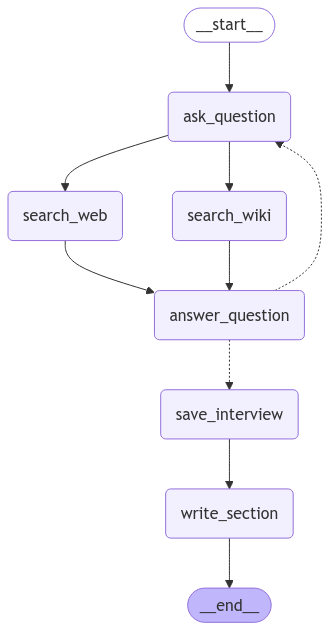

In [27]:
interview_buider = StateGraph(InterviewState)

# Add nodes
interview_buider.add_node("ask_question", generate_question)
interview_buider.add_node("search_web",search_web)
interview_buider.add_node("search_wiki", search_wiki)
interview_buider.add_node("answer_question", generate_answer)
interview_buider.add_node("save_interview",save_interview)
interview_buider.add_node("write_section", write_section)

# Add edges
interview_buider.add_edge(START, "ask_question")
interview_buider.add_edge("ask_question", "search_web")
interview_buider.add_edge("ask_question", "search_wiki")
interview_buider.add_edge(["search_web","search_wiki"], "answer_question")
interview_buider.add_conditional_edges("answer_question", route_messages, ["ask_question","save_interview"])
interview_buider.add_edge("save_interview","write_section")
interview_buider.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph= interview_buider.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [28]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Stanford University', name='AI Analyst 1', role='Research Scientist', description='Dr. AI Analyst 1 is a renowned expert in natural language processing and machine learning. With a Ph.D. in Computer Science from Stanford, she has published numerous papers on the application of deep learning to text analysis. Her research focuses on developing more accurate and efficient methods for sentiment analysis and topic modeling.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic:

In [31]:
messages = [HumanMessage(
    content=f"So you said you were writting an article on {topic}?"
)]
thread = {"configurable":{"thread_id":"2"}}
interview = interview_graph.invoke({
    "analyst":analysts[0],
    "messages":messages,
    "max_num_turns":2
}, thread)
Markdown(interview["sections"][0])

Question:  I'm Maya Ramos, a tech journalist, and I'm excited to be speaking with Alex Chen from Stanford University about the benefits of adopting LangGraph as an agent framework. I've heard that LangGraph has some game-changing capabilities in natural language processing and machine learning.

Let's dive right in! Can you tell me, what are some of the most significant advantages of using LangGraph over other agent frameworks? Are there any specific use cases where LangGraph really shines?
Query:  LangGraph benefits adoption agent framework
Query:  LangGraph benefits adoption agent framework
Wiki Docs:  <Document source="https://en.wikipedia.org/wiki/Semantic_Web" page=""/>
The Semantic Web, sometimes known as Web 3.0 (not to be confused with Web3), is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies suc

## Strategic Benefits of Adopting LangGraph as an Agent Framework

### Summary
The adoption of LangGraph as an agent framework presents a strategic opportunity for organizations seeking to leverage the power of artificial intelligence (AI) in their operations. With its robust features, including state management, cyclic workflows, and seamless integration of human input, LangGraph enables developers to build production-ready AI applications that can handle complex, multi-step processes.

The benefits of adopting LangGraph as an agent framework are multifaceted:

*   **Improved decision-making**: LangGraph's graph-based architecture allows for dynamic decision-making, making it ideal for advanced applications.
*   **Enhanced memory management**: The framework's robust memory management capabilities enable developers to create sophisticated conversational partners capable of maintaining context, learning from past interactions, and providing personalized responses based on historical data.
*   **Increased tool integration options**: LangGraph's seamless integration with other tools and frameworks makes it an ideal choice for building production-ready AI agents.

### Sources

[1] https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r/
[2] https://blog.premai.io/open-source-agentic-frameworks-langgraph-vs-crewai-more/
[3] https://www.getzep.com/ai-agents/langchain-agents-langgraph
[4] https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31

## Parallelize Interviews: Map-Reduce

We will parallelize the interviews via the `Send()` API, a map step.

We combine them into the  report body in a reduce map.

### Finalize

We add a final step to  write an intro and conclusion.

In [29]:
class ResearchGraphState(TypedDict):
    topic: str # Research Topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analysts asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Inroduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final Report

In [30]:
def create_analysts(state: ResearchGraphState):

    """Create analysts"""
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")

    # Enforce structured output
    structured_llm = model.with_structured_output(Perspectives)

    # System Message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )

    analysts = structured_llm.invoke(
            [
                SystemMessage(content=system_message),
                HumanMessage(content="Generate the complete set of analysts with all required fields.")
            ]
        )

    return {"analysts": analysts.analysts}

def human_feedback(state: ResearchGraphState):
    """No operation node: Here comes the human feedback"""
    pass

In [31]:
def initiate_all_interviews(state: ResearchGraphState):
    """This is the 'map' step where we run each interview sub-graph using Send API"""
    
    # Check if there is human feedback
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [
            Send("conduct_interview", {
                "analyst": analyst,
                "topic": topic,
                "messages": [
                    HumanMessage(
                        content=f"So you said you were writting an article on {topic}?"
                    )
                ]
            }) for analyst in state["analysts"]
        ]

In [32]:
report_writter_instructions="""You are a technicalwritter creating a report on this topic:
{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task is the following:


1. You will be given a collection of memos form yor analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all those memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown format.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources secction with the `## Sources` header.
8. List your sources in order and do not repeat.

Example:
[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}
"""

In [33]:
def writte_report(state: ResearchGraphState):

    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    system_message = report_writter_instructions.format(
        topic=topic, context=formatted_str_sections
    )

    report = answer_agent.invoke([
        SystemMessage(content=system_message)
    ] + [HumanMessage(
        content="Write a report based upon these memos."
    )])

    return {"content":report.content}

In [34]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}.

You will be given all of the sections of the report.

Your job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Do not include a pre-amble for either section.

Target around 200 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title

For yout introduction, use ## Introduction as the second header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formated_str_sections}

"""

In [35]:
def write_introduction(state: ResearchGraphState):

    # Ful set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections
    formatted_str_sections = "\n\n".join(
        [
            f"{section}" for section in sections
        ]
    )

    # Summarize the sections into a final report
    instructions = intro_conclusion_instructions.format(topic=topic, formated_str_sections=formatted_str_sections)
    introduction = answer_agent.invoke(
        [SystemMessage(content=instructions)] + 
        [
            HumanMessage(content="Write the report introduction")
        ]
    )

    return {"introduction": introduction}

def write_conclusion(state: ResearchGraphState):

    # Ful set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections
    formatted_str_sections = "\n\n".join(
        [
            f"{section}" for section in sections
        ]
    )

    # Summarize the sections into a final report
    instructions = intro_conclusion_instructions.format(topic=topic, formated_str_sections=formatted_str_sections)
    conclusion = answer_agent.invoke(
        [SystemMessage(content=instructions)] + 
        [
            HumanMessage(content="Write the report conclusion")
        ]
    )

    return {"conclusion": conclusion}

def finalize_report(state: ResearchGraphState):

    """This is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion"""

    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report":final_report}

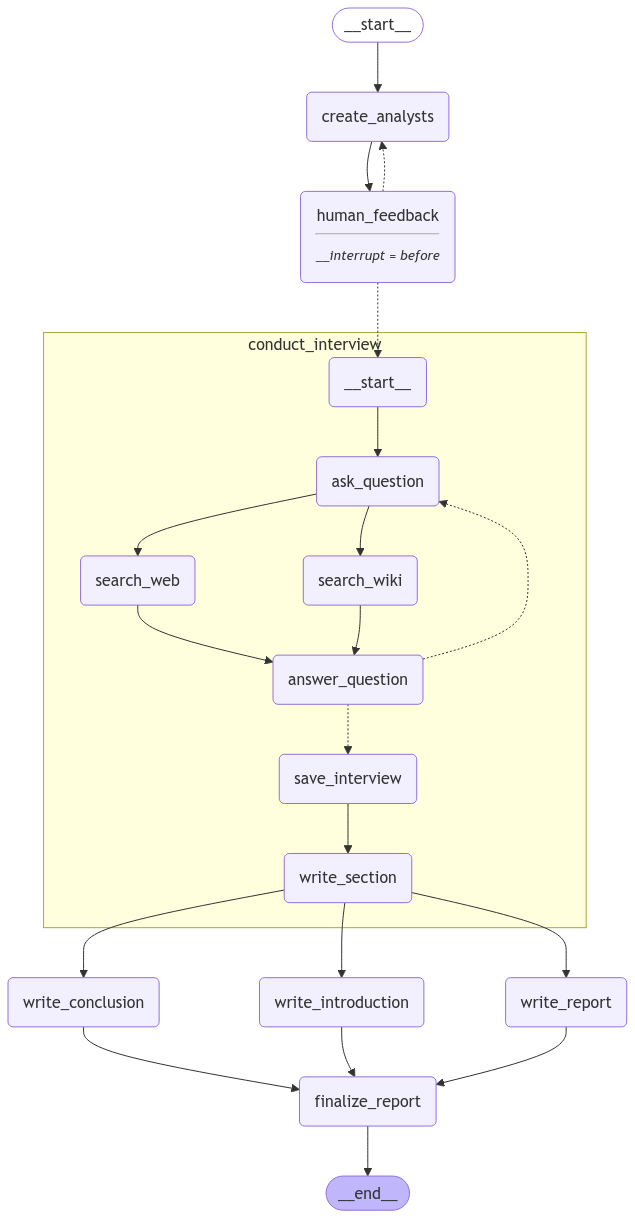

In [36]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_buider.compile())
builder.add_node("write_report", writte_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# Add logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts","human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts","conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion","write_introduction", "write_report"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [37]:
# inputs
max_analysts = 3
topic = """The benefits of adopting running as a health habit"""
thread = {"configurable":{"thread_id":"1"}}

# Run the graph until the first interruption
for event in graph.stream({
    "topic":topic,
    "max_analysts":max_analysts
}, thread,stream_mode="values"):
    analysts = event.get("analysts","")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)

Name: Dr. Emma Taylor
Affiliation: University of Health Sciences
Role: Health Researcher
Description: Dr. Taylor is a renowned expert in the field of health research, with a focus on the benefits of adopting running as a health habit. She has conducted extensive studies on the physical and mental health benefits of regular exercise, including reduced risk of chronic diseases and improved mental well-being.
--------------------------------------------------
Name: Coach Ryan Thompson
Affiliation: FitLife Gym
Role: Personal Trainer
Description: Coach Thompson is a certified personal trainer with over 10 years of experience in helping clients achieve their fitness goals. He specializes in running training programs, and has worked with numerous athletes to improve their performance and overall health.
--------------------------------------------------
Name: Dr. Sophia Patel
Affiliation: Sports Medicine Institute
Role: Sports Medicine Specialist
Description: Dr. Patel is a sports medicine sp

In [38]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":"Add in a psychologist that connects running with mental health"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe3582-4de9-6c26-8002-4e4298b06efd'}}

In [39]:
# CHeck
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get("analysts","")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)

Name: Dr. Emma Taylor
Affiliation: University of Health Sciences
Role: Health Researcher
Description: Dr. Taylor is a renowned expert in the field of health research, with a focus on the benefits of adopting running as a health habit. She has conducted extensive studies on the physical and mental health benefits of regular exercise, including reduced risk of chronic diseases and improved mental well-being.
--------------------------------------------------
Name: Coach Ryan Thompson
Affiliation: FitLife Gym
Role: Personal Trainer
Description: Coach Thompson is a certified personal trainer with over 10 years of experience in helping clients achieve their fitness goals. He specializes in running training programs, and has worked with numerous athletes to improve their performance and overall health.
--------------------------------------------------
Name: Dr. Sophia Patel
Affiliation: Sports Medicine Institute
Role: Sports Medicine Specialist
Description: Dr. Patel is a sports medicine sp

In [40]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe3582-f90c-637b-8004-cad97c8cbe98'}}

In [41]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--None--")
    node_name= next(iter((event.keys())))
    print(node_name)

Question:  I'm thrilled to be speaking with Dr. Emma Taylor today! I'm Maya Ramos, a health journalist, and I'm excited to learn more about the benefits of running from your expertise.

Dr. Taylor, thank you for taking the time to chat with me today! I'd love to dive right in. Can you share with me one surprising benefit that people might not know about when it comes to adopting running as a health habit?
Question:  I'm Maya Ramos, a health journalist, and I'm thrilled to be speaking with Dr. Sophia Patel today about the benefits of running for overall health and well-being.

Dr. Patel, thank you so much for taking the time to chat with me! I'd love to dive right in. Can you start by sharing one surprising finding from your research on the benefits of regular physical activity, specifically running? What was it that really stood out to you as a key takeaway?
Question:  I'm actually writing an article on "The Mental Edge: How Runners Can Unlock Their Full Potential with Sports Psycholog

In [48]:
final_state = graph.get_state(thread)
report = final_state.values.get("final_report").messages[0]["content"]
Markdown(report)

# **The Benefits of Running: A Holistic Perspective**

## Introduction

Running is a popular form of exercise that has been practiced for centuries, with its benefits extending far beyond individual physical and mental health. As we delve into the world of running, it becomes clear that this activity has a profound impact on various aspects of our lives, from social determinants to community well-being.

This report aims to provide an in-depth examination of the benefits of adopting running as a health habit, exploring its effects on physical and mental health, social determinants, and community well-being. We will examine the scientific evidence supporting these claims, drawing from various sources and studies to present a comprehensive overview of the advantages of running.

Through this report, we hope to inspire individuals to incorporate running into their lifestyle, not only for personal benefits but also for its potential to positively impact society as a whole. By understanding the far-reaching effects of running, we can work towards creating healthier, more resilient communities that value physical activity and mental well-being.

In the following sections, we will explore:

* The physical health benefits of running, including reduced risk of chronic diseases and improved cardiovascular health
* The mental health benefits of running, such as alleviating symptoms of depression and anxiety
* The social determinants influenced by running, including access to healthcare, education, and economic opportunities
* The intersection of sports psychology and Western sports, highlighting the importance of mental strategies and motivational factors in running

By examining these aspects, we hope to provide a holistic perspective on the benefits of running, demonstrating its potential to transform lives and communities.